In [34]:
import numpy as np
import pandas as pd
from numpy import sqrt 
import random
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from io import StringIO

pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 20)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trainData/11newer.csv')
data

,loc,lvl,e1,a1,s1,c1,g1,sc1,or1,e2,a2,s2,c2,g2,sc2,or2,our_gp
0,13.0,4.0,0.266394,0.214989,0.006726,137.468750,-0.042087,101.000000,0.0,0.282912,0.209429,0.018630,161.034775,0.237497,101.300003,1.0,1.00
1,289.0,2.0,0.582370,0.413295,0.015896,111.440895,0.409375,91.000000,0.0,0.307700,0.226964,0.022136,162.991364,0.153069,302.899994,1.0,-0.50
2,378.0,5.0,0.293621,0.207248,0.023449,158.180756,-0.021424,115.800003,1.0,0.296940,0.215774,0.010631,70.896591,-0.036685,50.000000,0.0,-1.00
3,465.0,5.0,0.303189,0.217590,0.018688,179.730103,0.055015,126.820000,1.0,0.339706,0.236765,0.020588,180.404358,0.258059,157.000000,0.0,-2.50
4,530.0,4.0,0.282912,0.209429,0.018630,161.034775,0.237497,100.000000,1.0,0.266394,0.214989,0.006726,137.468750,-0.042087,209.199997,0.0,-1.00
5,553.0,5.0,0.211612,0.165838,0.008190,132.687210,0.042689,117.870003,0.0,0.287531,0.201784,0.020771,165.046829,0.010958,102.500000,1.0,3.32
6,10.0,4.0,0.313875,0.201790,0.026110,132.178818,0.048456,131.660004,0.0,0.296433,0.212476,0.026511,151.113602,0.265221,100.000000,1.0,-0.50
7,134.0,5.0,0.375072,0.147721,0.040392,104.324623,-0.554207,80.000000,0.0,0.467981,0.346992,0.019412,153.341675,0.155362,100.000000,1.0,-14.25
8,41.0,2.0,0.437500,0.250000,0.000000,67.400002,-0.992188,70.900002,0.0,0.313325,0.233171,0.020978,160.224792,0.175431,124.500000,1.0,1.00
9,45.0,2.0,0.262518,0.219016,0.011092,188.492126,0.175912,261.500000,1.0,0.351954,0.197578,0.011007,113.984093,-0.027023,106.000000,0.0,1.00


#Анализ данных

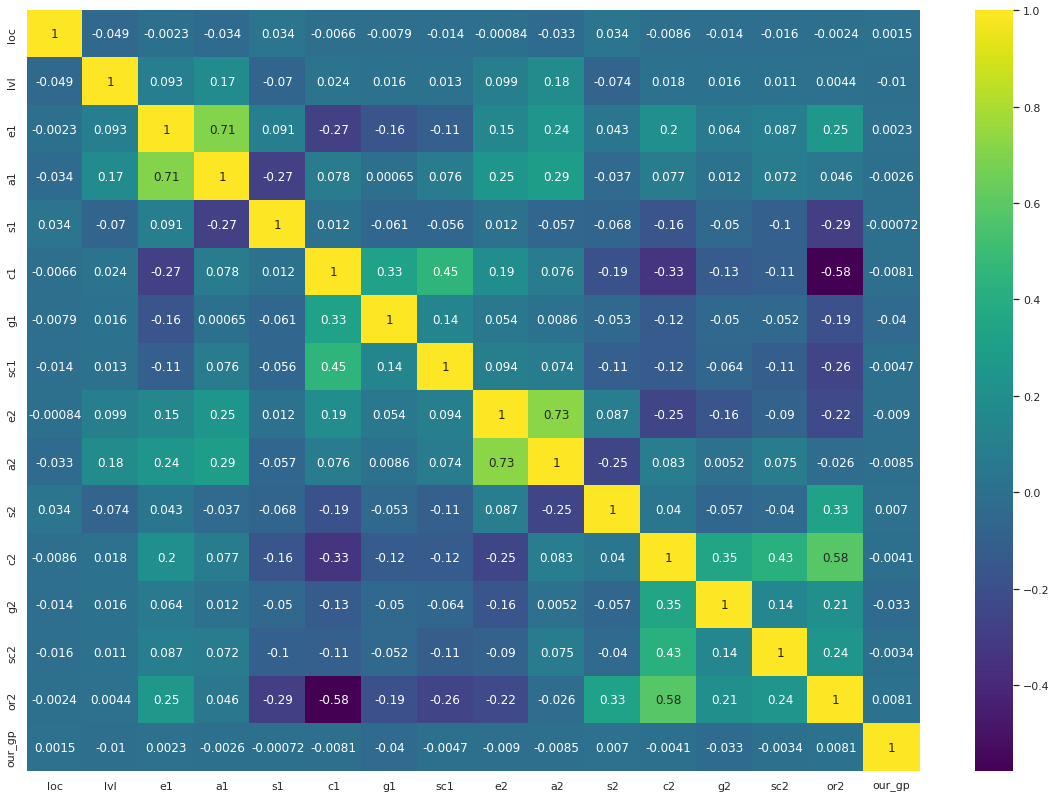

In [37]:
data = data.drop('or1', axis=1)
corr = data.corr()
sns.set(rc={'figure.figsize': (20, 14)})
sns.heatmap(corr, cmap='viridis', annot=True)
plt.show()

In [38]:
data = data.drop(['e1', 'e2'], axis=1)

In [39]:
end_col = data.shape[1] - 1
x = data.drop('our_gp', axis=1)
y = data['our_gp']

In [40]:
end_col

13

In [41]:
x

,loc,lvl,a1,s1,c1,g1,sc1,a2,s2,c2,g2,sc2,or2
0,13.0,4.0,0.214989,0.006726,137.468750,-0.042087,101.000000,0.209429,0.018630,161.034775,0.237497,101.300003,1.0
1,289.0,2.0,0.413295,0.015896,111.440895,0.409375,91.000000,0.226964,0.022136,162.991364,0.153069,302.899994,1.0
2,378.0,5.0,0.207248,0.023449,158.180756,-0.021424,115.800003,0.215774,0.010631,70.896591,-0.036685,50.000000,0.0
3,465.0,5.0,0.217590,0.018688,179.730103,0.055015,126.820000,0.236765,0.020588,180.404358,0.258059,157.000000,0.0
4,530.0,4.0,0.209429,0.018630,161.034775,0.237497,100.000000,0.214989,0.006726,137.468750,-0.042087,209.199997,0.0
5,553.0,5.0,0.165838,0.008190,132.687210,0.042689,117.870003,0.201784,0.020771,165.046829,0.010958,102.500000,1.0
6,10.0,4.0,0.201790,0.026110,132.178818,0.048456,131.660004,0.212476,0.026511,151.113602,0.265221,100.000000,1.0
7,134.0,5.0,0.147721,0.040392,104.324623,-0.554207,80.000000,0.346992,0.019412,153.341675,0.155362,100.000000,1.0
8,41.0,2.0,0.250000,0.000000,67.400002,-0.992188,70.900002,0.233171,0.020978,160.224792,0.175431,124.500000,1.0
9,45.0,2.0,0.219016,0.011092,188.492126,0.175912,261.500000,0.197578,0.011007,113.984093,-0.027023,106.000000,0.0


In [42]:
y

0         1.00
1        -0.50
2        -1.00
3        -2.50
4        -1.00
5         3.32
6        -0.50
7       -14.25
8         1.00
9         1.00
         ...  
66545    -4.50
66546    -1.00
66547     2.00
66548     2.50
66549     3.50
66550    -0.50
66551    -2.50
66552     3.00
66553    -1.00
66554     3.00
Name: our_gp, Length: 66555, dtype: float64

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape

((53244, 13), (53244,))

In [44]:
mean_x = x_train.mean(axis=0)
std_x = x_train.std(axis=0)

def norm(x):
  return (x - mean_x) / std_x

x_train = norm(x_train)
x_test = norm(x_test)

In [45]:
mean_x

loc    334.308955
lvl      3.439054
a1       0.228153
s1       0.017072
c1     135.503283
g1       0.016181
sc1    128.534566
a2       0.228392
s2       0.016944
c2     137.062239
g2       0.033109
sc2    129.865522
or2      0.516377
dtype: float64

In [46]:
std_x

loc    209.754670
lvl      1.522510
a1       0.082144
s1       0.011809
c1      30.227543
g1       0.667205
sc1     63.125370
a2       0.080121
s2       0.011037
c2      29.374533
g2       0.576434
sc2     63.197807
or2      0.499736
dtype: float64

In [47]:
# Приводим значения ответов в диапазон от 0 до 1
min_y = y_train.min()
amp = y_train.max() - min_y

# отклонение от минимума к амплитуде
y_train = (y_train - min_y) / amp
y_test = (y_test - min_y) / amp

min_y, amp

(-158.30000305, 375.19999695)

In [48]:
x_test

,loc,lvl,a1,s1,c1,g1,sc1,a2,s2,c2,g2,sc2,or2
38914,-1.393575,-0.288375,-0.245518,0.493398,0.242230,0.120136,-0.436189,-0.389118,-0.801468,-0.713700,-0.097704,-0.086483,-1.033300
7351,1.357257,1.025245,0.052317,-0.561344,0.291775,-0.187351,-0.374248,1.480261,0.223573,0.554202,0.212085,0.356096,0.967755
4707,1.261908,-0.945185,1.006062,0.010905,-0.588098,-0.251142,-1.158561,-0.537515,0.245659,0.953052,0.254726,0.521133,0.967755
11375,0.089109,-0.945185,-1.220623,0.323068,-0.873100,-0.411362,-0.155794,0.283149,0.895948,0.574118,0.004989,0.106562,0.967755
63147,1.199931,1.025245,1.446723,0.198178,0.590137,0.208603,3.968380,2.621342,-1.178077,0.360952,0.004428,-0.472572,-1.033300
51282,1.619468,1.025245,-0.049488,-0.901480,0.460501,0.112602,-0.400545,1.480261,0.223573,0.554202,0.212085,0.443757,0.967755
62931,0.675508,2.338865,0.351345,-0.832583,-0.437125,-0.268575,-0.250051,0.121850,0.724238,-0.161700,0.160405,-0.373676,0.967755
31617,-0.416243,1.682055,-1.347000,-0.368548,-0.545438,-0.452364,-0.452030,-0.702337,0.378974,-0.764055,0.015747,0.351032,0.967755
39793,-0.745199,0.368435,-0.638071,0.192076,0.646830,0.263106,-0.193180,-1.092116,3.839694,-2.717501,-0.153036,-1.407731,-1.033300
19865,-0.034845,0.368435,0.362216,-1.206540,0.330250,0.260518,-0.452030,-0.156197,-0.026682,0.724619,0.348868,-0.252944,0.967755


In [49]:
y_test

38914    0.440032
7351     0.428571
4707     0.431237
11375    0.429904
63147    0.432889
51282    0.408582
62931    0.415245
31617    0.405117
39793    0.423241
19865    0.424574
           ...   
29365    0.427239
34166    0.427239
25201    0.419243
66137    0.393923
43485    0.379264
40250    0.424574
26172    0.429904
15796    0.395256
31616    0.419243
6477     0.413913
Name: our_gp, Length: 13311, dtype: float64

#Нейронка

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [51]:
# Размерность нейросети
n_input = x_train.shape[1]
n_hidden = n_input * 2 - 1
n_input, n_hidden

(13, 25)

In [92]:
model = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.Dropout(p=.25),
            nn.ReLU(),
            nn.Linear(n_hidden, n_input),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(n_input, 1),
            nn.Sigmoid(),
        ).to(device)
    
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.3, threshold=1e-2, patience=2)

model

Sequential(
  (0): Linear(in_features=13, out_features=25, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): ReLU()
  (5): Linear(in_features=25, out_features=13, bias=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=13, out_features=1, bias=True)
  (9): Sigmoid()
)

In [63]:
# Создаём датасеты
batch_size = 1

train_dataset = TensorDataset(torch.tensor(np.array(x_train)).float(), torch.tensor(np.array(y_train)).float())
test_dataset  = TensorDataset(torch.tensor(np.array(x_test)).float(), torch.tensor(np.array(y_test)).float())

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_dataset, batch_size=batch_size)

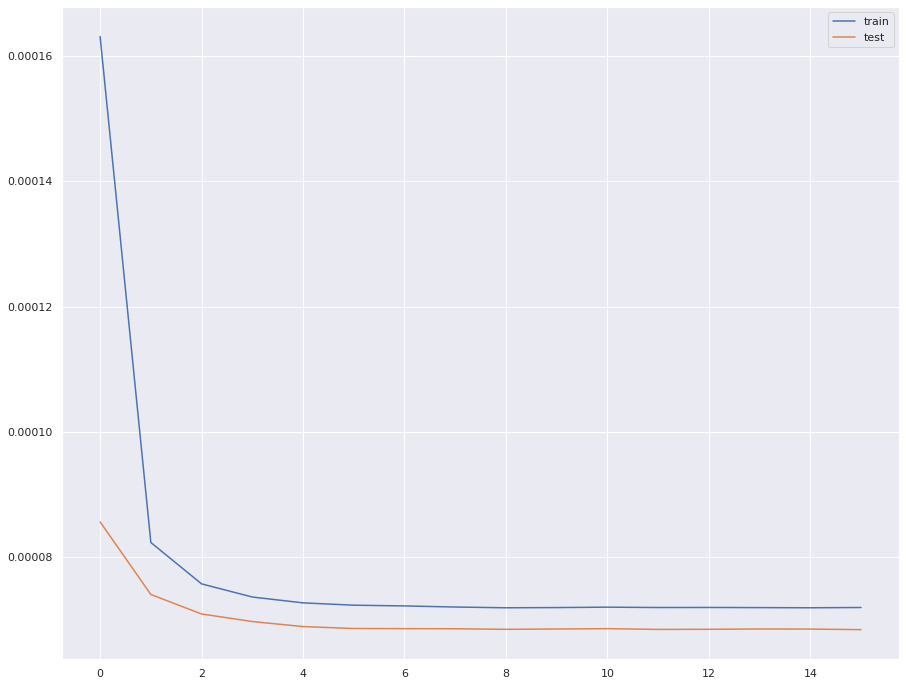

last 3 train losses: [7.195052603492513e-05, 7.192315388238057e-05, 7.196691876742989e-05]
last 3 test losses: [6.853754894109443e-05, 6.852368824183941e-05, 6.843177834525704e-05]
eph 16
lr: 2.6999999999999996e-07


  0%|          | 0/53244 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [93]:
# Обучаем
epochs = 50
train_losses = []
test_losses  = []
lrs = []

for eph in range(epochs):
  train_loss = 0
  test_loss = 0

  lrs.append(optimizer.param_groups[0]['lr'])

  print('eph', eph)
  print('lr:', lrs[-1])
    
  for x, y in tqdm(train_dl):
      x = x.to(device)
      y = y.to(device)
      pred = model(x)
      loss = criterion(pred.squeeze(), y.squeeze())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.detach().cpu()
    
  avg_train_loss = train_loss * batch_size / x_train.size
  train_losses.append(avg_train_loss)
  scheduler.step(avg_train_loss)
    
  for x, y in tqdm(test_dl):
      x = x.to(device)
      y = y.to(device)
      pred = model(x)
      loss = criterion(pred.squeeze(), y.squeeze())
      test_loss += loss.detach().cpu()
        
  test_losses.append(test_loss * batch_size / x_test.size)
    
  # Выводим график
  clear_output()
  sns.set(rc={'figure.figsize': (15, 12)})
  sns.lineplot(x=np.arange(0, len(train_losses)), y=np.array(train_losses), label='train')
  sns.lineplot(x=np.arange(0, len(test_losses)), y=np.array(test_losses), label='test')
  plt.show()

  print('last 3 train losses:', list(map(torch.Tensor.item, train_losses[-3:])))
  print('last 3 test losses:', list(map(torch.Tensor.item, test_losses[-3:])))

In [94]:
train_losses

[tensor(0.0002),
 tensor(8.2343e-05),
 tensor(7.5737e-05),
 tensor(7.3640e-05),
 tensor(7.2707e-05),
 tensor(7.2335e-05),
 tensor(7.2218e-05),
 tensor(7.2043e-05),
 tensor(7.1923e-05),
 tensor(7.1956e-05),
 tensor(7.2021e-05),
 tensor(7.1964e-05),
 tensor(7.1972e-05),
 tensor(7.1951e-05),
 tensor(7.1923e-05),
 tensor(7.1967e-05)]

In [95]:
test_losses

[tensor(8.5631e-05),
 tensor(7.4043e-05),
 tensor(7.0931e-05),
 tensor(6.9725e-05),
 tensor(6.8923e-05),
 tensor(6.8614e-05),
 tensor(6.8590e-05),
 tensor(6.8576e-05),
 tensor(6.8485e-05),
 tensor(6.8536e-05),
 tensor(6.8590e-05),
 tensor(6.8469e-05),
 tensor(6.8490e-05),
 tensor(6.8538e-05),
 tensor(6.8524e-05),
 tensor(6.8432e-05)]

In [96]:
lrs

[1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 3e-06,
 3e-06,
 3e-06,
 3e-06,
 9e-07,
 9e-07,
 9e-07,
 2.6999999999999996e-07,
 2.6999999999999996e-07]

In [97]:
pred = model(torch.tensor(np.array(x_test)).float().to(device)).flatten()

# Возвращаем к прежнему размеру
pred = pred.cpu() * amp + min_y 
y_test = torch.tensor(np.array(y_test)).float().cpu() * amp + min_y

print(torch.tensor(np.array(y_test)).float().cpu())

tensor([  6.8000,   2.5000,   3.5000,  ..., -10.0000,  -1.0000,  -3.0000])


In [98]:
err = abs(pred - y_test).mean()
print('Средняя ошибка:', err.item())

Средняя ошибка: 4.322094917297363


In [99]:
table = 'Ответ сети,Верный ответ,Разница\n'
for idx in range(30):
    i = random.randint(0, y_test.shape[0] - 1)
    table += (str(pred[i].item()) + ',' + str(y_test[i].item()) + ',' + str((pred[i] - y_test[i]).item())) + '\n'

pd.read_csv(StringIO(table))

,Ответ сети,Верный ответ,Разница
0,-0.076492,18.279999,-18.356491
1,0.197662,-19.799988,19.997650
2,0.113068,2.000015,-1.886948
3,0.209457,-18.279999,18.489456
4,0.343872,-1.000000,1.343872
5,0.094025,2.500000,-2.405975
6,0.153030,1.000000,-0.846970
7,0.237793,1.000000,-0.762207
8,-2.828949,2.000015,-4.828964
9,-0.014984,-7.219986,7.205002


In [100]:
# Сохраняем модель
torch.onnx.export(model.to(torch.float32),               
                  torch.randn(n_input).to(torch.float32).to(device),                         
                  'Qlab11.onnx',
                  input_names=['input_1'])